# Zaimportowane biblioteki i lista analizowanych plików

In [1]:
#docrepr
ip = get_ipython()
ip.sphinxify_docstring = True
ip.enable_html_pager = True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

In [3]:
files = sorted(glob('data/*.xls'))

files #lista plików

['data/0.000.xls', 'data/0.200.xls', 'data/0.535.xls', 'data/0.535X.xls']

# Skrypt odczytujący i przetwarzający dane z plików

In [4]:
def process(file_path):

    """
    file_path has to be str
    """
    
    init_data = pd.read_excel(file_path)
    data = init_data[['Date&Time', 'Unit']]
    values = []

    for i in init_data['MainValue']:
        value = i.replace(',', '.')
        values.append(float(value))

    data.insert(loc = 1, column = 'Value', value = values)

    minutes = []
    means = []
    errors = []

    minute = 0

    while not data.empty:
        minutes.append(minute)
        minute += 1
        means.append(data['Value'][:300].mean())
        errors.append(data['Value'][:300].sem())
        data = data[300:]

    final_df = pd.DataFrame(
        {
            'minute' : minutes,
            'mean' : means,
            'error' : errors
        }
    )

    return final_df, minutes, means

# Skrypt rysujący wykres

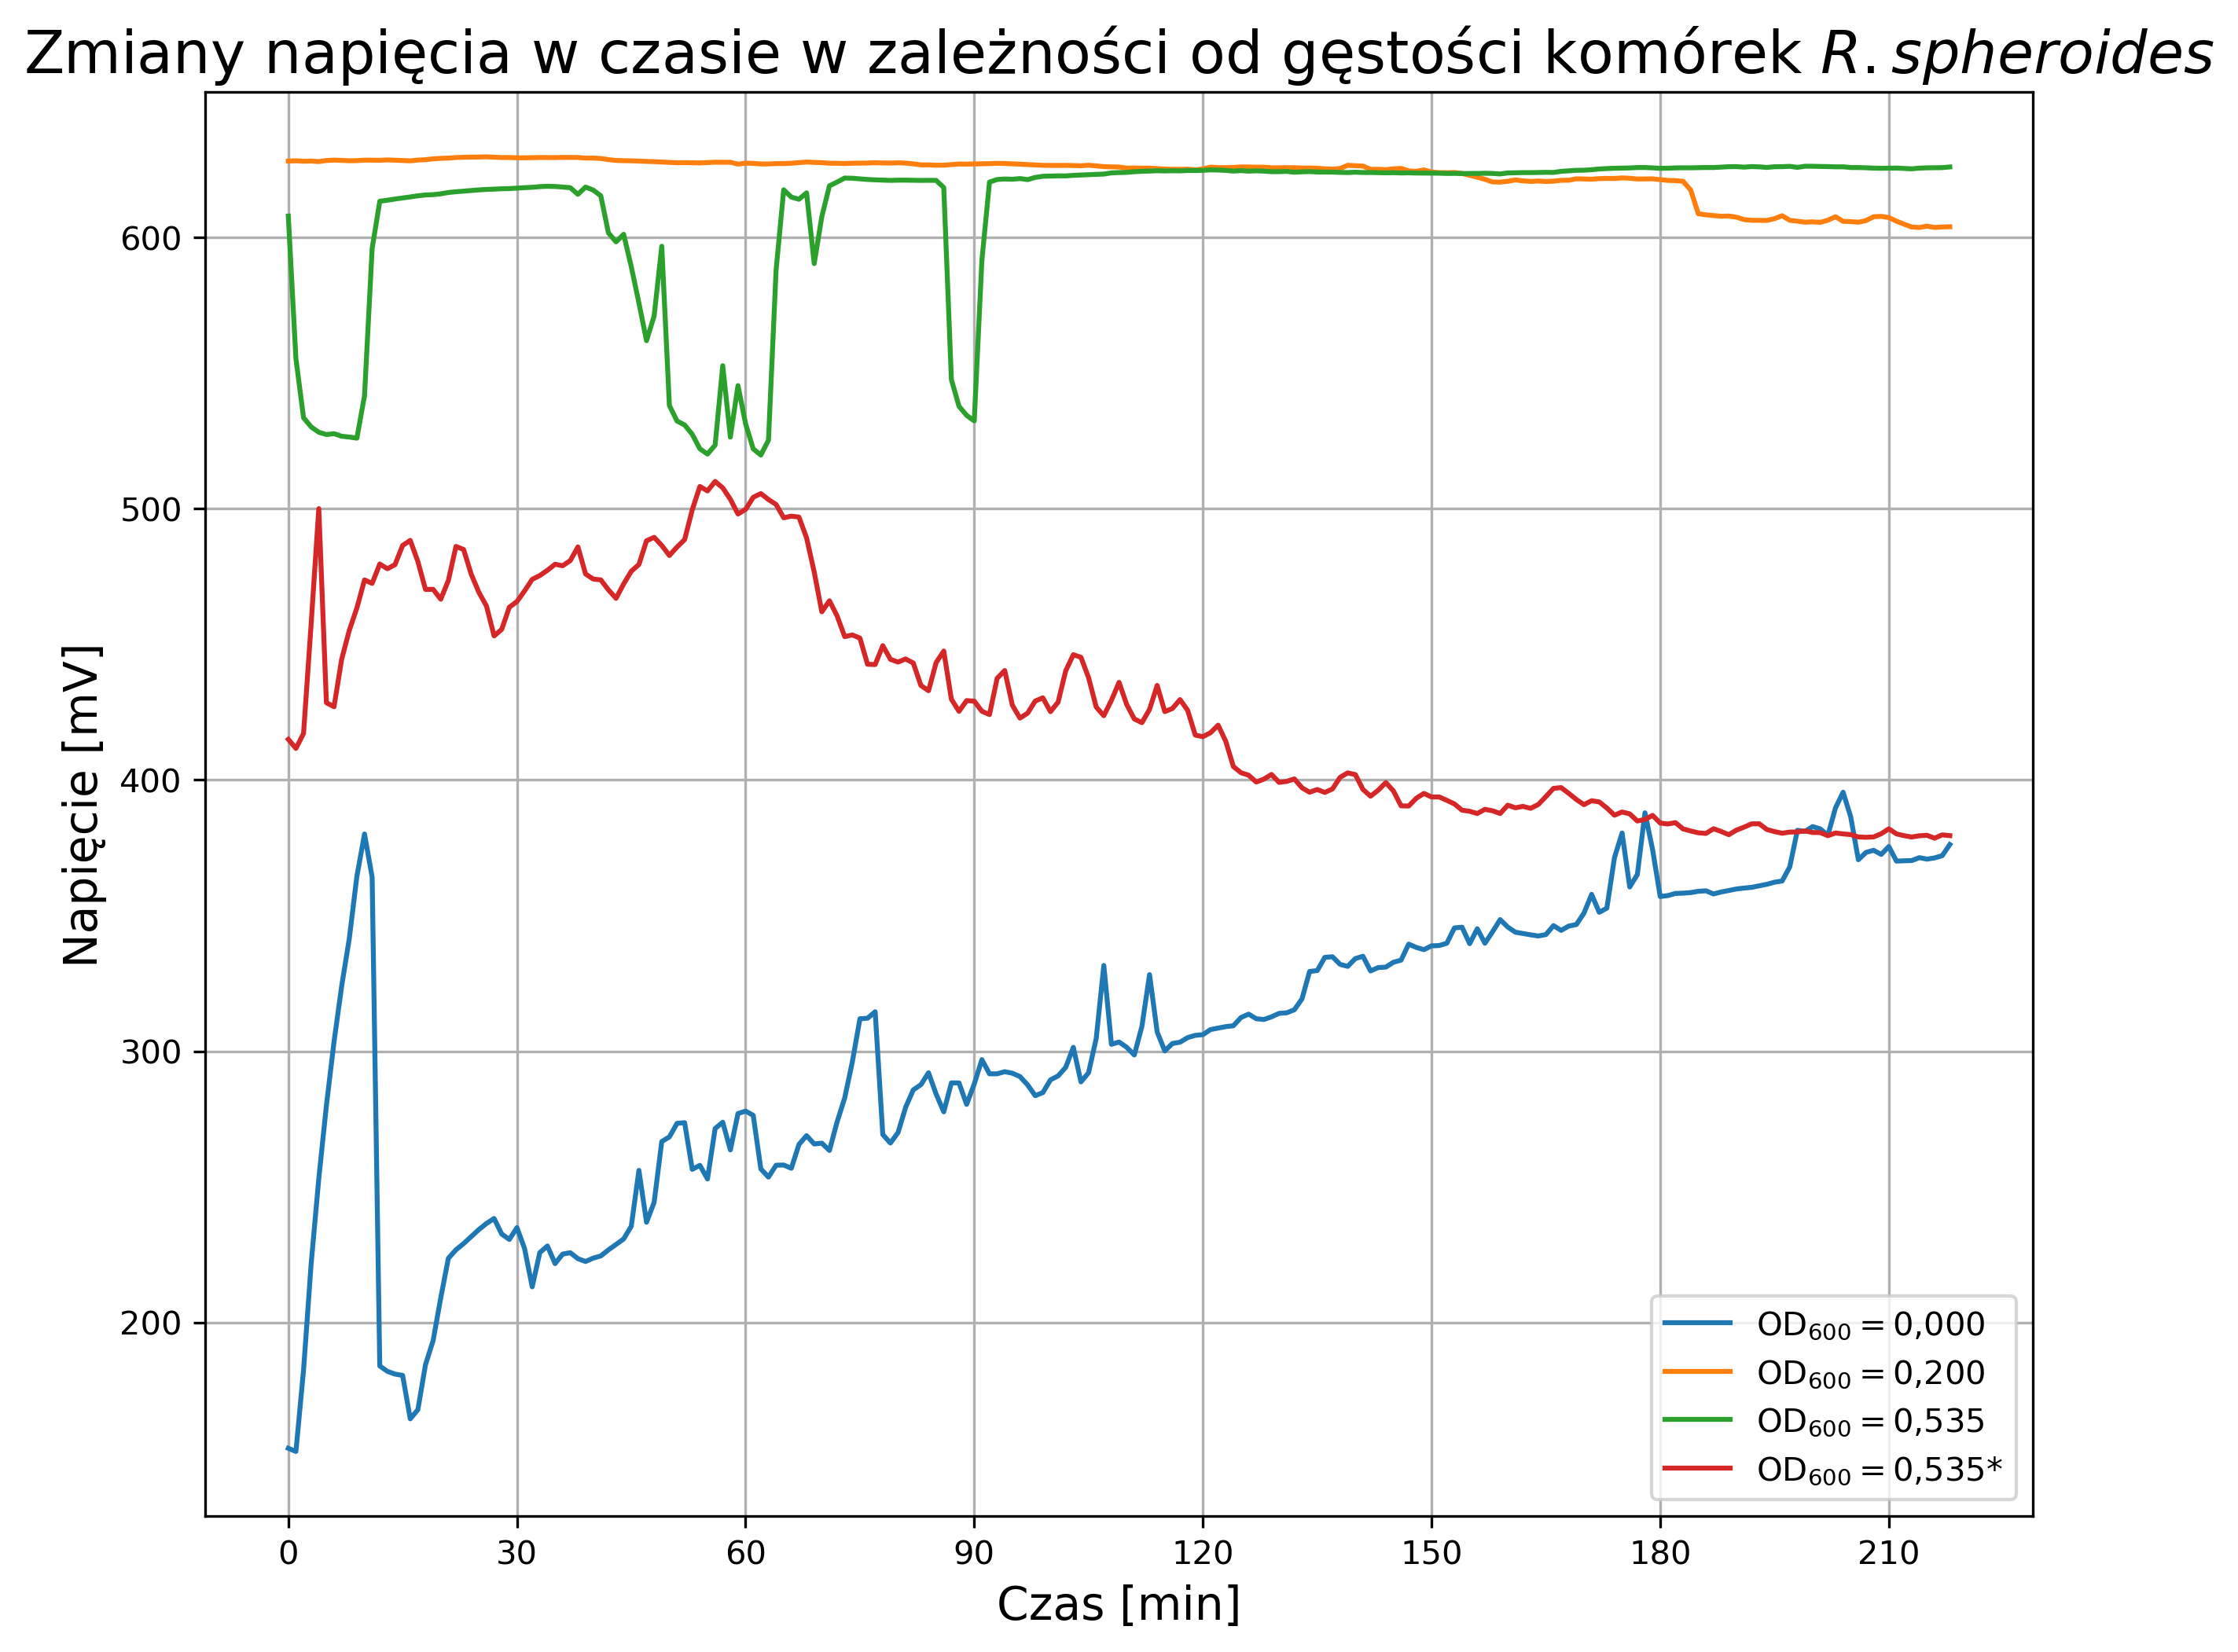

In [5]:
plt.figure(figsize = (10,8), dpi = 300)

legend = []

factor = 1

for file in files:

    od_value = file[5:-4].replace('.', ',')
    if 'X' in od_value:
        od_value = od_value.replace('X', '*')

    final_df, minutes, means = process(file)
    
    plt.errorbar(
        x = final_df['minute'],
        y = final_df['mean']*factor,
        # yerr = final_df['error'],
        fmt = '-',
    )
    legend_rec = 'OD$_{600} = $' + f'{od_value}'
    legend.append(legend_rec)
    factor = 1000

plt.title(
    '''Zmiany napięcia w czasie w zależności od gęstości komórek $R. spheroides$''', 
    fontdict = {
        'fontsize' : 18,
        'multialignment' : 'center'
    }
)
plt.ylabel(
    'Napięcie [mV]', 
    fontdict = {'fontsize' : 14}
)
plt.xlabel(
    'Czas [min]', 
    fontdict = {'fontsize' : 14}
)
plt.legend(legend)
plt.grid()
plt.xticks(minutes[::30])

plt.show()